In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date
from collections import Counter
from sklearn.model_selection import cross_validate
import warnings
warnings.simplefilter(action='ignore')
%matplotlib inline

### Read Data

In [2]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
enrollment_ = pd.read_csv('dataset/Enrollment Data (collated final).csv')
enrollment = enrollment_.iloc[:-184,:]
engagement = pd.read_excel('dataset/Patient Engagement Events Data (collated final).xlsx')

In [3]:
print('engagement.csv',engagement.shape)
print('train.csv',train.shape)
print('enrollment.csv',enrollment.shape); 

engagement.csv (176615, 8)
train.csv (1996, 6)
enrollment.csv (2217, 8)


In [4]:
# Columns names
engagement.columns = [column.replace(' ','_') for column in engagement.columns]
train.columns = [column.replace(' ','_') for column in train.columns][:-1] + ['Flag']
test.columns = [column.replace(' ','_') for column in test.columns][:-1] + ['Flag']
enrollment.columns = [column.replace(' ','_') for column in enrollment_.columns]

In [5]:
train.head()

,Index_Id,Hospital_Id,Patient_Id,Registration_Date,Procedure_Date,Flag
0,0,19,20908,2018-02-15,2018-02-15,0
1,1,19,29539,2018-03-02,2018-07-09,0
2,2,24,19574,2018-02-12,2018-03-16,1
3,3,19,62597,2018-05-18,2018-06-12,0
4,4,19,61998,2018-05-17,2018-06-14,0


In [6]:
test.head()

,Index_Id,Hospital_Id,Patient_Id,Registration_Date,Procedure_Date,Flag
0,0,19,16444,2/3/18,3/12/18,-1
1,1,19,15574,2/1/18,3/30/18,-1
2,2,19,15156,1/30/18,3/1/18,-1
3,3,19,14769,1/26/18,4/20/18,-1
4,4,19,19757,2/13/18,2/28/18,-1


In [7]:
enrollment.head()

,Hospital_Id,Patient_Id,Registration_Date,Procedure_Date,Email,SMS,Date_of_Birth,Gender
0,19.0,14722.0,2018/1/25,2018/3/27,True,True,1950/1/27,Female
1,19.0,14723.0,2018/1/25,2018/2/1,True,True,1955/2/17,Male
2,19.0,14724.0,2018/1/25,2018/3/21,True,True,1962/6/14,Female
3,19.0,14725.0,2018/1/25,2018/2/28,True,True,1948/1/18,Male
4,19.0,14726.0,2018/1/25,2018/2/7,True,True,1967/1/8,Female


### Repetitive Data Check

In [8]:
unique_train = train.Patient_Id.unique()
unique_enroll = enrollment.Patient_Id.unique()
print(train.shape[0],len(unique_train))
print(enrollment.shape[0],len(unique_enroll))

1996 1996
2217 2217


In [9]:
# Check if there are any repetitive Patient_Id
for i in enumerate(unique_train):
    if len(train[train.Patient_Id == i[1]])!=1:
        print(i)
for i in enumerate(unique_enroll):
    if len(enrollment[enrollment.Patient_Id == i[1]])!=1:
        print(i)

In [10]:
ct = 0
for i in unique_train:
    if i not in unique_enroll:
        ct+=1
if ct == 0:
    print('All patients in train.csv can be found in enrollment.csv.')

All patients in train.csv can be found in enrollment.csv.


In [11]:
ct = 0
for i in unique_enroll:
    if i not in unique_train:
        ct+=1
if ct!=0:
    print('There are {} patients that appears in enrollment.csv, but not in train.csv.'.format(ct))

There are 221 patients that appears in enrollment.csv, but not in train.csv.


### Merge train and enrollment data

In [12]:
asd = enrollment[enrollment.Patient_Id.isin(train.Patient_Id)].iloc[:,[1,4,5,6,7]].sort_values(by=('Patient_Id'));asd.head()

,Patient_Id,Email,SMS,Date_of_Birth,Gender
1,14723.0,True,True,1955/2/17,Male
4,14726.0,True,True,1967/1/8,Female
6,14728.0,False,True,1943/2/22,Male
8,14731.0,True,True,1957/6/21,Male
9,14732.0,True,True,1955/11/29,Male


In [13]:
asd_1 = train.sort_values(by=('Patient_Id')).iloc[:,1:]; asd_1.head()

,Hospital_Id,Patient_Id,Registration_Date,Procedure_Date,Flag
1199,19,14723,2018-01-25,2018-02-01,0
1317,19,14726,2018-01-25,2018-02-07,0
1945,19,14728,2018-01-25,2018-03-28,0
1828,19,14731,2018-01-25,2018-02-28,0
1027,19,14732,2018-01-25,2018-05-17,1


In [14]:
ct = 0
for i in range(asd.shape[0]):
    if asd.iloc[i,0] != asd_1.iloc[i,1]:
        ct+=1
if ct==0:
    print('Every pair matches, ready to merge!')

Every pair matches, ready to merge!


In [15]:
asd_1[asd.columns[1:]] = asd.iloc[:,1:]
asd_2 = asd_1.iloc[:,[1,0,2,3,5,6,7,8,4]];asd_2.head(5)

,Patient_Id,Hospital_Id,Registration_Date,Procedure_Date,Email,SMS,Date_of_Birth,Gender,Flag
1199,14723,19,2018-01-25,2018-02-01,NaN,NaN,NaN,NaN,0
1317,14726,19,2018-01-25,2018-02-07,True,True,1950/1/7,NaN,0
1945,14728,19,2018-01-25,2018-03-28,False,True,NaN,NaN,0
1828,14731,19,2018-01-25,2018-02-28,False,True,NaN,NaN,0
1027,14732,19,2018-01-25,2018-05-17,False,True,1945/10/14,Female,1


### Missing Data

In [16]:
missing = pd.DataFrame({'# Missing Data' :list(asd_2.isnull().sum()),
                        'Percentage(%)':list(round(asd_2.isnull().sum()*100/asd_2.shape[0],2))})
missing.index = asd_2.columns; missing

,# Missing Data,Percentage(%)
Patient_Id,0,0.00
Hospital_Id,0,0.00
Registration_Date,0,0.00
Procedure_Date,0,0.00
Email,221,11.07
SMS,221,11.07
Date_of_Birth,647,32.41
Gender,1027,51.45
Flag,0,0.00


### Exploratory Data Analysis

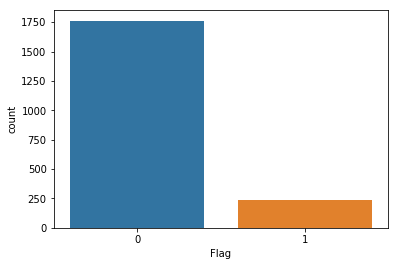

In [17]:
# Flag
sns.countplot(asd_2.Flag)

([<matplotlib.patches.Wedge at 0x11219fba8>,
 [Text(-0.0501914,1.09885,'nan'),
  Text(-0.710303,-0.839922,'Female'),
  Text(0.806637,-0.747888,'Male')],
 [Text(-0.0273771,0.599375,'51.5%'),
  Text(-0.387438,-0.458139,'24.7%'),
  Text(0.439984,-0.407939,'23.8%')])

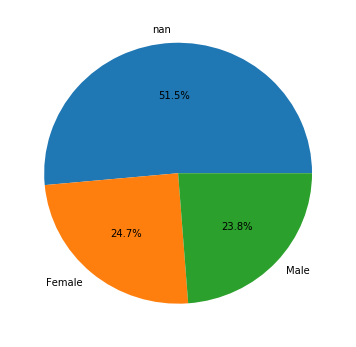

In [18]:
# Gender
gender = Counter(asd_2.Gender)
labels = list(gender.keys())
sizes = list(gender.values())
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

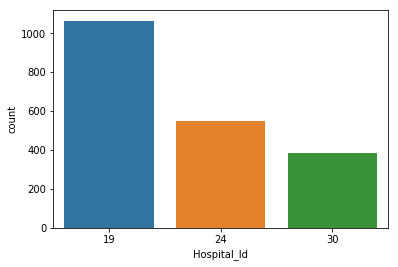

In [19]:
# Hospital Id
sns.countplot(asd_2.Hospital_Id)

### Dummie Encoding & Date2Days Conversion

In [20]:
# Hospital_Id
dummie_hospital_Ids = ['Hospital_19','Hospital_24','Hospital_30']
asd_2[dummie_hospital_Ids] = pd.get_dummies(pd.Series(asd_2.Hospital_Id))
asd_3 = asd_2.iloc[:,[0,9,10,11,2,3,4,5,6,7,8]];asd_3.head(5)

,Patient_Id,Hospital_19,Hospital_24,Hospital_30,Registration_Date,Procedure_Date,Email,SMS,Date_of_Birth,Gender,Flag
1199,14723,1,0,0,2018-01-25,2018-02-01,NaN,NaN,NaN,NaN,0
1317,14726,1,0,0,2018-01-25,2018-02-07,True,True,1950/1/7,NaN,0
1945,14728,1,0,0,2018-01-25,2018-03-28,False,True,NaN,NaN,0
1828,14731,1,0,0,2018-01-25,2018-02-28,False,True,NaN,NaN,0
1027,14732,1,0,0,2018-01-25,2018-05-17,False,True,1945/10/14,Female,1


In [21]:
def date2days_reg(a):
    ymd = [int(i) for i in a.split('-')]
    a = date(ymd[0],ymd[1],ymd[2])
    b = date(2018,1,25)
    #print(a,b)
    #print((a-b).days)
    return (a-b).days

# Test Case
asdf = asd_3.iloc[0,4]
date2days_reg(asdf)

0

In [22]:
def date2days_proc(a):
    ymd = [int(i) for i in a.split('-')]
    a = date(ymd[0],ymd[1],ymd[2])
    b = date(2018,2,1)
    #print(a,b)
    #print((a-b).days)
    return (a-b).days

# Test Case
asdf = asd_3.iloc[0,5]
date2days_proc(asdf)

0

In [23]:
# Registration_Date & Procedure_Date
asd_4 = asd_3.copy()
asd_4['Registration_Date'] = asd_3['Registration_Date'].apply(date2days_reg)
asd_4['Procedure_Date'] = asd_3['Procedure_Date'].apply(date2days_proc); asd_4.head()

,Patient_Id,Hospital_19,Hospital_24,Hospital_30,Registration_Date,Procedure_Date,Email,SMS,Date_of_Birth,Gender,Flag
1199,14723,1,0,0,0,0,NaN,NaN,NaN,NaN,0
1317,14726,1,0,0,0,6,True,True,1950/1/7,NaN,0
1945,14728,1,0,0,0,55,False,True,NaN,NaN,0
1828,14731,1,0,0,0,27,False,True,NaN,NaN,0
1027,14732,1,0,0,0,105,False,True,1945/10/14,Female,1


In [24]:
# Email
dummie_Email = ['Email_False','Email_True','Email_Missing']
asd_5 = asd_4.copy()
asd_5[dummie_Email] = pd.get_dummies(pd.Series(asd_4.Email), dummy_na=True)
asd_5 = asd_5.loc[:, asd_5.columns != 'Email']; asd_5.head()

,Patient_Id,Hospital_19,Hospital_24,Hospital_30,Registration_Date,Procedure_Date,SMS,Date_of_Birth,Gender,Flag,Email_False,Email_True,Email_Missing
1199,14723,1,0,0,0,0,NaN,NaN,NaN,0,0,0,1
1317,14726,1,0,0,0,6,True,1950/1/7,NaN,0,0,1,0
1945,14728,1,0,0,0,55,True,NaN,NaN,0,1,0,0
1828,14731,1,0,0,0,27,True,NaN,NaN,0,1,0,0
1027,14732,1,0,0,0,105,True,1945/10/14,Female,1,1,0,0


In [25]:
# SMS
dummie_SMS = ['SMS_False','SMS_True','SMS_NaN']
asd_6 = asd_5.copy()
asd_6[dummie_SMS] = pd.get_dummies(pd.Series(asd_5.SMS), dummy_na=True)
asd_6 = asd_6.loc[:, asd_6.columns != 'SMS']; asd_6.head()

,Patient_Id,Hospital_19,Hospital_24,Hospital_30,Registration_Date,Procedure_Date,Date_of_Birth,Gender,Flag,Email_False,Email_True,Email_Missing,SMS_False,SMS_True,SMS_NaN
1199,14723,1,0,0,0,0,NaN,NaN,0,0,0,1,0,0,1
1317,14726,1,0,0,0,6,1950/1/7,NaN,0,0,1,0,0,1,0
1945,14728,1,0,0,0,55,NaN,NaN,0,1,0,0,0,1,0
1828,14731,1,0,0,0,27,NaN,NaN,0,1,0,0,0,1,0
1027,14732,1,0,0,0,105,1945/10/14,Female,1,1,0,0,0,1,0


In [26]:
# Gender
dummie_Gender = ['Gender_Famale','Gender_Male','Gender_NaN']
asd_7 = asd_6.copy()
asd_7[dummie_Gender] = pd.get_dummies(pd.Series(asd_6.Gender), dummy_na=True)
asd_7 = asd_7.loc[:, asd_7.columns != 'Gender']; asd_7.head()

,Patient_Id,Hospital_19,Hospital_24,Hospital_30,Registration_Date,Procedure_Date,Date_of_Birth,Flag,Email_False,Email_True,Email_Missing,SMS_False,SMS_True,SMS_NaN,Gender_Famale,Gender_Male,Gender_NaN
1199,14723,1,0,0,0,0,NaN,0,0,0,1,0,0,1,0,0,1
1317,14726,1,0,0,0,6,1950/1/7,0,0,1,0,0,1,0,0,0,1
1945,14728,1,0,0,0,55,NaN,0,1,0,0,0,1,0,0,0,1
1828,14731,1,0,0,0,27,NaN,0,1,0,0,0,1,0,0,0,1
1027,14732,1,0,0,0,105,1945/10/14,1,1,0,0,0,1,0,1,0,0


In [27]:
# Create a column that indicates if Date_of_Birth is originally missing
asd_8 = asd_7.copy();asd_8.head()

,Patient_Id,Hospital_19,Hospital_24,Hospital_30,Registration_Date,Procedure_Date,Date_of_Birth,Flag,Email_False,Email_True,Email_Missing,SMS_False,SMS_True,SMS_NaN,Gender_Famale,Gender_Male,Gender_NaN
1199,14723,1,0,0,0,0,NaN,0,0,0,1,0,0,1,0,0,1
1317,14726,1,0,0,0,6,1950/1/7,0,0,1,0,0,1,0,0,0,1
1945,14728,1,0,0,0,55,NaN,0,1,0,0,0,1,0,0,0,1
1828,14731,1,0,0,0,27,NaN,0,1,0,0,0,1,0,0,0,1
1027,14732,1,0,0,0,105,1945/10/14,1,1,0,0,0,1,0,1,0,0


In [28]:
def BirthDate2days(a):
    if type(a)==float:
        return a
    ymd = [int(i) for i in a.split('/')]

    a = date(ymd[0],ymd[1],ymd[2])
    b = date(1930,1,1) # 1931/3/15
    #print(a,b)
    #print((a-b).days)
    return (a-b).days

# Test Case
for i in range(5):
    asdf = asd_7.iloc[i,6]; 
    print(BirthDate2days(asdf))

nan
7311
nan
nan
5765


In [29]:
# Date_of_Birth
asd_9 = asd_8.copy()
asd_9['Date_of_Birth'] = asd_8['Date_of_Birth'].apply(BirthDate2days);asd_9.head()

,Patient_Id,Hospital_19,Hospital_24,Hospital_30,Registration_Date,Procedure_Date,Date_of_Birth,Flag,Email_False,Email_True,Email_Missing,SMS_False,SMS_True,SMS_NaN,Gender_Famale,Gender_Male,Gender_NaN
1199,14723,1,0,0,0,0,NaN,0,0,0,1,0,0,1,0,0,1
1317,14726,1,0,0,0,6,7311.0,0,0,1,0,0,1,0,0,0,1
1945,14728,1,0,0,0,55,NaN,0,1,0,0,0,1,0,0,0,1
1828,14731,1,0,0,0,27,NaN,0,1,0,0,0,1,0,0,0,1
1027,14732,1,0,0,0,105,5765.0,1,1,0,0,0,1,0,1,0,0


In [30]:
asd_10 = asd_9.loc[:, asd_9.columns != 'Patient_Id']; asd_10.head()

,Hospital_19,Hospital_24,Hospital_30,Registration_Date,Procedure_Date,Date_of_Birth,Flag,Email_False,Email_True,Email_Missing,SMS_False,SMS_True,SMS_NaN,Gender_Famale,Gender_Male,Gender_NaN
1199,1,0,0,0,0,NaN,0,0,0,1,0,0,1,0,0,1
1317,1,0,0,0,6,7311.0,0,0,1,0,0,1,0,0,0,1
1945,1,0,0,0,55,NaN,0,1,0,0,0,1,0,0,0,1
1828,1,0,0,0,27,NaN,0,1,0,0,0,1,0,0,0,1
1027,1,0,0,0,105,5765.0,1,1,0,0,0,1,0,1,0,0


In [31]:
asd_10.Date_of_Birth.fillna(asd_10.Date_of_Birth.mean(), inplace=True);
asd_10['Date_of_Birth'] = asd_10['Date_of_Birth'].astype(int);asd_10.head()

,Hospital_19,Hospital_24,Hospital_30,Registration_Date,Procedure_Date,Date_of_Birth,Flag,Email_False,Email_True,Email_Missing,SMS_False,SMS_True,SMS_NaN,Gender_Famale,Gender_Male,Gender_NaN
1199,1,0,0,0,0,11256,0,0,0,1,0,0,1,0,0,1
1317,1,0,0,0,6,7311,0,0,1,0,0,1,0,0,0,1
1945,1,0,0,0,55,11256,0,1,0,0,0,1,0,0,0,1
1828,1,0,0,0,27,11256,0,1,0,0,0,1,0,0,0,1
1027,1,0,0,0,105,5765,1,1,0,0,0,1,0,1,0,0


In [32]:
asd_11 = asd_10.iloc[:,[0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,6]];asd_11.head()

,Hospital_19,Hospital_24,Hospital_30,Registration_Date,Procedure_Date,Date_of_Birth,Email_False,Email_True,Email_Missing,SMS_False,SMS_True,SMS_NaN,Gender_Famale,Gender_Male,Gender_NaN,Flag
1199,1,0,0,0,0,11256,0,0,1,0,0,1,0,0,1,0
1317,1,0,0,0,6,7311,0,1,0,0,1,0,0,0,1,0
1945,1,0,0,0,55,11256,1,0,0,0,1,0,0,0,1,0
1828,1,0,0,0,27,11256,1,0,0,0,1,0,0,0,1,0
1027,1,0,0,0,105,5765,1,0,0,0,1,0,1,0,0,1


In [196]:
asd_11.columns

Index(['Hospital_19', 'Hospital_24', 'Hospital_30', 'Registration_Date',
       'Procedure_Date', 'Date_of_Birth', 'Email_False', 'Email_True',
       'Email_Missing', 'SMS_False', 'SMS_True', 'SMS_NaN', 'Gender_Famale',
       'Gender_Male', 'Gender_NaN', 'Flag'],
      dtype='object')

### Correlation

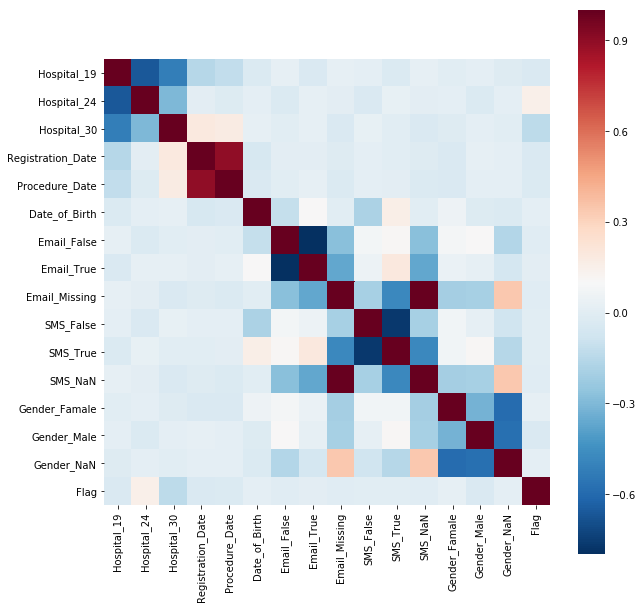

In [33]:
#mask = np.zeros_like(asd_11.corr(), dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True
corrmat = asd_11.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corrmat, 
            #mask = mask,
            square=True,
            cmap = 'RdBu_r');

In [34]:
# Higest Correlation Features with Target Value
pd.DataFrame(asd_11.corr()['Flag'].sort_values(ascending = False)).iloc[1:,:]

,Flag
Hospital_24,0.156179
Gender_Famale,0.018354
Gender_NaN,0.011218
Date_of_Birth,0.010557
Email_True,0.006642
SMS_False,0.002222
SMS_True,0.000974
Email_False,-0.003937
SMS_NaN,-0.004511
Email_Missing,-0.004511


Positive Correlation Features:
    Hospital_24: 0.156
    Gender_Famale: 0.018
    
Negative Correlation Features:
    Hospital_30: -0.134
    Hospital_19: -0.034
    Gender_Male: -0.032
    Procedure_Date: -0.032

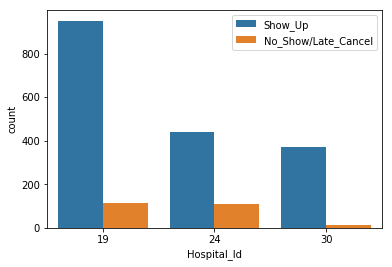

In [35]:
# Hospital_Id & No_Show/Late_Cancel Flag
ax = sns.countplot(x = "Hospital_Id", 
                   hue="Flag",
                   data = asd_2)
plt.legend(['Show_Up', 'No_Show/Late_Cancel'])

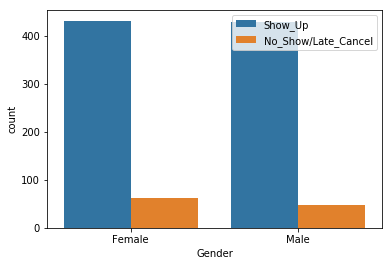

In [36]:
ax = sns.countplot(x = "Gender", 
                   hue="Flag",
                   data = asd_2)
plt.legend(['Show_Up', 'No_Show/Late_Cancel'])

In [186]:
X = asd_11.loc[:, asd_11.columns != 'Flag']
y = asd_11.loc[:, asd_11.columns == 'Flag']

In [187]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
y = y.Flag

### RandomForest

In [197]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search

In [198]:
parameters = {'max_depth':(2,3,4,5,6,7,8,9,10), 
              'min_samples_split':[2,3,4,5,6,7,8,9,10],
              'min_samples_leaf':(1,2,3,4,5)}

clf = grid_search.GridSearchCV(RandomForestClassifier(), 
                               parameters,
                               scoring='accuracy')

In [200]:
clf.fit(X, y)
clf.best_params_

{'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2}

In [168]:
asd = cross_validate(clf.best_estimator_,
                     X, y, 
                     scoring = ['accuracy','recall','precision','f1'],
                     cv=20)
print(asd['train_accuracy'].mean(),asd['test_accuracy'].mean())

0.8828973730924025 0.8529874987498751


In [176]:
clf.best_estimator_.fit(X,y)
rt = clf.best_estimator_.predict(X)
for i in range(len(rt)):
    if rt[i]!=0:
        print(i)

### Logistic Regression

In [182]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()#class_weight = 'balanced')

parameters = {'C':(1e-3,1e-2,1e-1,1,1e1,1e2,1e3)}

clf = grid_search.GridSearchCV(lr, 
                               parameters,
                               scoring='accuracy')
clf.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': (0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0)},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [183]:
asd = cross_validate(clf.best_estimator_,
                     X, y, 
                     scoring = ['accuracy','recall','precision','f1'],
                     cv=20)
print(asd['train_accuracy'].mean(),asd['test_accuracy'].mean())

0.8827655860602464 0.8827854785478548


In [85]:
lr.coef_

array([[0.06167917, 0.22316206]])

In [185]:
rt = lr.predict(X)
for i in range(len(rt)):
    if rt[i]!=0:
        print(i)

ValueError: X has 15 features per sample; expecting 2

## Others

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

gradient = GradientBoostingClassifier()
asd = cross_validate(gradient,
                X, y, 
                scoring = ['accuracy','recall','precision','f1'],
                cv=20)
print(asd['train_accuracy'].mean(),asd['test_accuracy'].mean())

0.8992988541671931 0.5495540054005401


In [42]:
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf', probability=True, C = 3)
asd = cross_validate(svc,
                X, y, 
                scoring = ['accuracy','recall','precision','f1'],
                cv=20)
print(asd['train_accuracy'].mean(),asd['test_accuracy'].mean())

0.8833457270921338 0.8827854785478548
